
**Mini Project: Predictive Maintenance using Machine Learning**
**Project Description**

In this mini project, you will develop a predictive maintenance system using machine
learning techniques. 

The goal is to predict machine failures based on sensor data from
industrial equipment. 

You will work with a dataset containing various sensor measurements
and use two different machine learning models of your choice.

**-----------------Objectives-----------------**
- Load dependencies
- Load dataset
- Preprocess data, look for missing values etc.
- Perform gridsearch hyperparameter tuning
- Train Random Forest Classifier
- Evaluate performance using ML metrics
- Visualize results

**------------------Solution------------------**

**Step 1:** Loading dependencies:

The first step is to load in the necessary dependencies, as i will be using these packages to load the training data, and train the models.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, auc
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense, Dropout
from imblearn.under_sampling import RandomUnderSampler

**Step 2:** Loading the dataset with `pandas`

I will only load relevant data, since i am only interested in the datapoints for Air temperature, Process temperature, Rotational speed, Torque, Tool wear and Machine failure.
I then make sure that there are no missing values in the dataset, and i count the number of machine failures.

In [2]:
data = pd.read_csv("ai4i2020.csv", usecols=['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', "Machine failure"])

# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

# Check the number of Machine failure
print("\nNumber of positives and negative Machine failures: \n", data['Machine failure'].value_counts())

data

Missing values:
 Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
dtype: int64

Number of positives and negative Machine failures: 
 Machine failure
0    9661
1     339
Name: count, dtype: int64


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,298.1,308.6,1551,42.8,0,0
1,298.2,308.7,1408,46.3,3,0
2,298.1,308.5,1498,49.4,5,0
3,298.2,308.6,1433,39.5,7,0
4,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0
9996,298.9,308.4,1632,31.8,17,0
9997,299.0,308.6,1645,33.4,22,0
9998,299.0,308.7,1408,48.5,25,0


**Step 3:** Choice of models

The miniproject dictates, that we should choose two different models to try and predict machine failures based on the collected data. 

- Random Forests                    (Lecture 5)
- Artificial Neural Networks (ANNs) (Lecture 9)

### **Dataset Format Considerations**

The provided dataset consists of 10,000 rows and the following columns:
- **Features**: Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min].
- **Target Variable**: Machine failure (binary classification: 0 or 1).

**Selected Models:**
1. **Random Forests**: Chosen for robustness and interpretability.
2. **Artificial Neural Networks**: Selected for handling complex patterns effectively.

Now that i have chosen the models i want to use, i have to train them on the data that has been provided. In order to do this, it is wise to first break up the data into training data and testing/validation data.

In [3]:
X = data[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
y = data['Machine failure']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

**Step 4:** Instantiate Models and Train on Data

Now the dataset has been separated into X, which contains all of the features, and the target variable in y.
I can now split the dataset into 80% training data and 20% testing data, and use this for training the models.

Before i can do that, i need to instantiate the models.
For the Random Forest Classifier, i would like to perform some hyperparameter tuning so i can find a set of hyperparameters that will yield the most accurate model. For this i use Grid Search.
Grid Search needs a hyperparameter grid to test, so i have found some typical ranges for each of the hyperparameters online and defined them in param_grid.

I ensure reproducibility by providing a random state, and the class weight handles the imbalanced datasheet, such that the weights are inversely proportional to class frequency.

For the Grid Search, i have chosen to set it to 3 folds and scoring using f1-score.


In [4]:
# Hyperparameter Tuning Random Forest Classifier - NOTE: Time Consuming, uncomment to test
RFModel = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight' : ['balanced', None]
}

# Perform grid search
grid_search = GridSearchCV(estimator=RFModel, param_grid=param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Parameters: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: 0.9213450766376686


**Step 5:** Testing and Validation

For the Random Forest Classifier, Grid Search provides the following output:

324 total fits tested:
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

Best Score: 0.708111173799546

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1939
           1       0.22      0.95      0.36        61

    accuracy                           0.90      2000
   macro avg       0.61      0.92      0.65      2000
weighted avg       0.97      0.90      0.92      2000



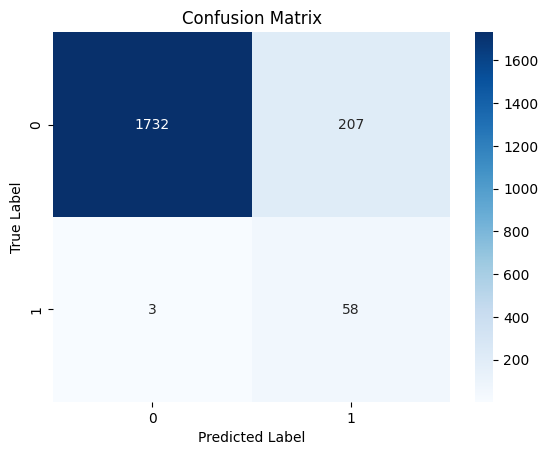

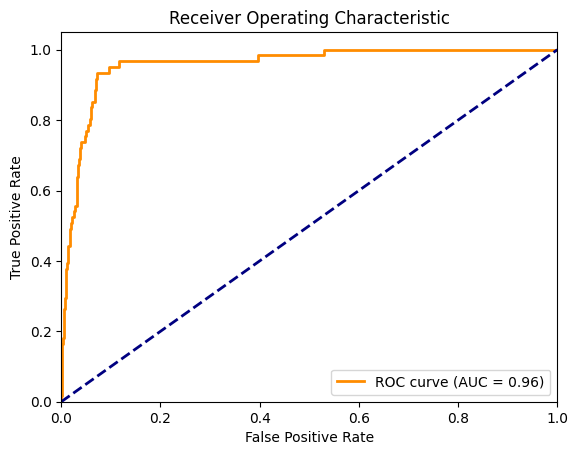

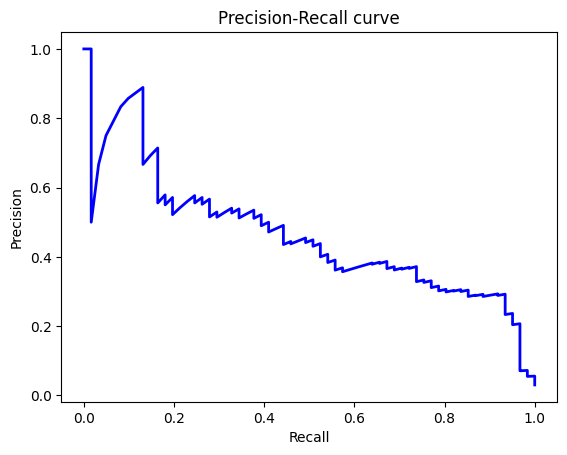

                   Feature  Importance
3              Torque [Nm]    0.322127
2   Rotational speed [rpm]    0.318849
4          Tool wear [min]    0.216961
0      Air temperature [K]    0.087141
1  Process temperature [K]    0.054923
Accuracy:  0.895
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94      1939
           1       0.22      0.95      0.36        61

    accuracy                           0.90      2000
   macro avg       0.61      0.92      0.65      2000
weighted avg       0.97      0.90      0.92      2000



In [ ]:
RFModel = RandomForestClassifier(max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50)

#----------------------------------Kfold-CrossValidation----------------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results for each fold
scores = []

# Cross-validation loop
for train_index, val_index in skf.split(X, y):
    # Split data into train and validation sets
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Apply undersampling to the training fold
    undersampler = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_fold, y_train_fold)

    # Train the model
    RFModel.fit(X_train_resampled, y_train_resampled)

    # Validate the model
    y_pred = RFModel.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_pred)

    # Store the score
    scores.append(accuracy)

# Print cross-validation results
print("Cross-validation scores:", scores)
print("Mean accuracy:", sum(scores) / len(scores))
print("Standard deviation:", np.std(scores))

#----------------------------------Kfold-CrossValidation----------------------------------------
RFModel.fit(X_train,y_train)

y_pred = RFModel.predict(X_test)
y_pred_proba = RFModel.predict_proba(X_test)[:, 1]

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()


# Assuming grid_result is the best Random Forest model from GridSearchCV
feature_importances = RFModel.feature_importances_
feature_names = X.columns  # Ensure feature names are taken from the correct DataFrame

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df)

print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))